## Практическая задача №1 по курсу "Биофизика возбудимой клетки"

В этой задаче мы рассматриваем формализм Ходжкина-Хаксли, исследуем влияние концентраций ионов, температуры и потенциалчувствительности токов на характеристики ответа модельного нейрона.

Мы используем средства языка `Python`. Рекомендуется установить его в виде дистрибутива [Anaconda](https://www.continuum.io/downloads). 

Для формулирования и решения систем дифференциальных уравнений будем использовать и модуль `PyDSTool`. Его можно установить командой `pip install pydstool`. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
style.use('ggplot')
rc('font', family='ubuntu') # эта строчка нужна в Ubuntu, чтобы русские буквы отображались в рисунках

In [3]:
from __future__ import division 

In [4]:
import PyDSTool as dst
from PyDSTool import Exp, Pow, Log, Par, Var, Fun

## Ионные равновесия

Большинство зависимостей мы будем задавать в символьном виде, т.е. в виде выражений. Для этого нам нужно объявить несколько параметров и переменных.

In [5]:
V = Var('V')  

Ci = Par('Ci')
Co = Par('Co')

nai = Par('nai') # концентрация натрия внутри клетки
nao = Par('nao') # концентрация натрия снаружи клетки
ki = Par('ki')   # концентрация калия внутри клетки
ko = Par('ko')   # концентрация калия снаружи клетки


F = 96485 # Кл/моль
R = 8314.4  # Universal gaz constant, мДж/(моль * Кельвин)

celsius = dst.Par('celsius')
T = 273 + celsius


charge = dst.Par('charge')



<font color=blue>**Электрохимический потенциал**</font>, из которого выводятся остальные выражения:

\begin{equation}
\bar\mu = \mu_0 + RT\ln c + zF\phi
\end{equation}


<font color=blue>**Уравнение Нернста**</font>, описывающее равновесный потенциал для отдельного иона ($\Delta \mu = 0$):

\begin{equation}
E =\Delta\phi = \phi_i - \phi_o= \frac{RT}{zF}\ln\frac{c_o}{c_i}
\end{equation}

<font color=blue>**Поток вещества через мембрану**</font> (уравнение электродиффузии Нернста-Планка):
\begin{equation}
-J = u c\frac{d\bar\mu}{dx} = uRT\frac{dc}{dx} + uczF\frac{d\phi}{dx}
\end{equation}

<font color=blue>**В приближении постоянного поля**</font>, т.е. $\frac{d\phi}{dx} = -\frac{\Delta\phi}{h} = -\frac{V}{h}$, где $h$ -- толщина мембраны, а $V$ -- трансмембранный потенциал, поток ионов описывается уравнением Гольдмана-Ходжкина-Катца:

\begin{equation}
J = P\frac{zFV}{RT}\frac{c_i - c_o e^{-\frac{zFV}{RT}}}{1 - e^{-\frac{zFV}{RT}}},
\end{equation}
где $P$ -- проницаемость мембраны для данного иона. Ток, переносимый потоком ионов: $I = zFJ$.

<p>
<font color=red>**Задание:** Выведите уравнение для потока ионов (ГХК) из уравнения Нернста-Планка</font>

In [6]:
# Cимвольные выражения для равновесного потенциала и для потока:

nernst = Fun(R*T*Log(Co/Ci)/F, ['Ci','Co'], 'nernst')

# (для простоты, с единичным зарядом)
GHK = Fun((F**2*V/(R*T))*(Ci - Co*Exp(-F*V/(R*T)))/(1 - Exp(-F*V/(R*T))),
              ['Ci','Co'], 'GHK')

Выразим потенциалы реверсии для натрия и калия через их внутри- и экстраклеточные концентрации

In [7]:
ena =  nernst(nai,nao) # потенциал реверсии для Na
ek = nernst(ki, ko)    # потенциал реверсии для K

elk = Par('elk') # потенциал реверсии для утечки


## Формализм Ходжкина-Хаксли

В формализме Ходжкина-Хаксли *мгновенный* ток имеет линейную зависимость от потенциала вида $i=g(V-V_r)$, где $g$ -- проводимость, $V_r$ -- потенциал реверсии для данного тока. Проводимость состоит из *максимальной* проводимости, умноженной на долю т.н. "воротных частиц", находящихся в открытом состоянии: $g = \bar{g}x^ay^b$. Воротные частицы -- это формальная абстракция, отражающая кинетику открывания-закрывания ансамбля каналов.

В классической модели Ходжкина-Хаксли натриевый ток имеет две воротные частицы: активационную $x:=m, a=3$ и инакцивационную $y:=h, b=1$. Калиевый ток описывается одной воротной частицей: $x:=n, a=4$, $y:=\_, b=0$. В других нейронах могут быть каливевые токи с инактивацией, натриевые токи без инактивации, а также смешанные токи. 

Кинетика воротных частиц описывается линейными дифференциальными уравнениями вида $\dot{x} = \alha(1-x)-\beta x$.
Константы скорости $\alpha$ и $\beta$ нелинейно зависят от потенциала, Ходжкин и Хаксли аппроксимировали их следующими зависимостями:

In [8]:
# "Стандартный" Ходжкин-Хаксли
malpha = 0.1*(V+40.0)/(1 - Exp(-(V+40)/10.))
mbeta = 4*Exp(-(V+65)/18.)

halpha = 0.07*Exp(-(V+65)/20.)
hbeta = 1/(1 + Exp(-(V+35)/10.))

nalpha = 0.01*(V+55)/(1 - Exp(-(V+55)/10.0))
nbeta = 0.125*Exp(-(V+65)/80.)


# Эквивалентная запись:
minf = 1/(1.0 + mbeta/malpha)
hinf = 1/(1.0 + hbeta/halpha)
ninf = 1/(1.0 + nbeta/nalpha)

mtau = 1./(malpha + mbeta)
htau = 1./(halpha + hbeta)
ntau = 1./(nalpha + nbeta)

In [9]:
vtest = linspace(-89, 45, 250)
kwx = dict(Exp='np.exp', Pow='np.power')

def eval_at(vstring, obj):
    return eval(str(obj.eval(V=vstring, **kwx)))

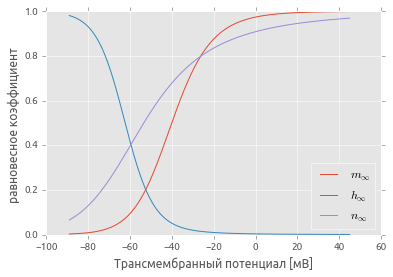

In [10]:
plot(vtest, eval_at('vtest', minf), label='$m_\infty$')
plot(vtest, eval_at('vtest', hinf), label='$h_\infty$')
plot(vtest, eval_at('vtest', ninf), label='$n_\infty$')
legend(loc='best')
xlabel(u'Трансмембранный потенциал [мВ]')
ylabel(u'равновесное коэффициент ')

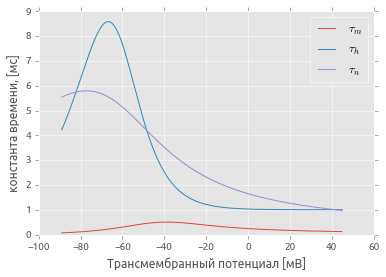

In [11]:
plot(vtest, eval_at('vtest', mtau), label='$\\tau_m$')
plot(vtest, eval_at('vtest', htau), label='$\\tau_h$')
plot(vtest, eval_at('vtest', ntau), label='$\\tau_n$')

legend(loc='best')
xlabel(u'Трансмембранный потенциал [мВ]')
ylabel(u'константа времени, [мс]')

Объявим наши воротные переменные:

In [12]:
m = Var('m')
h = Var('h')
n = Var('n')

Дифференциальные уравнения для воротных переменных однотипны:

In [13]:
mdot = (minf-m)/mtau
hdot = (hinf-h)/htau
ndot = (ninf-n)/ntau

**Мгновенные токи в формализме Ходжкина-Хаксли линейно зависят от потенциала (в отличие от приближения постоянного поля)**

In [14]:
gnabar = Par('gnabar') # макс. проводимость по Na+
gkbar = Par('gkbar')   # макс. проводимость по K+
glk = Par('glk')

In [15]:
ina = gnabar*m**3*h*(V-ena)
ik = gkbar*n**4*(V-ek)

ileak = glk*(V-elk)

Сложим все ионные токи, опосредуемые ионными механизмами:

In [16]:
Imech = ina + ik + ileak

In [17]:
Istim = Par('Istim')

В классической модели Ходжкина-Хаксли:
 - Ena = 50 мВ
 - Ek = -77 мВ
 - Elk = -54.4 мВ
 - темература: 6 $^\circ$C
 
Подберем соответствующие концентрации Na+ и К+ снаружи и внутри клетки:

In [18]:
print "Ek =", ek.eval(ki=75, ko=3,celsius=6)
print "Ena=", ena.eval(nai=20, nao=155,celsius=6)

Ek = -77.38905428990292
Ena= 49.23116679430405


Таблица параметров, которую будем использовать:

In [19]:
parameters = dict(nai = 20., nao = 155., gnabar = 120.0, 
                  ki = 75.,  ko = 3.,    gkbar = 36.0,
                  elk = -54.5,          glk  = 0.3,
                  celsius = 6., Istim=0)

Определим несколько вспомогательных функций, которые помогут нам задать начальные условия таким образом, чтобы при произвольно выбранном $V$ все воротные переменные имели свое стационарное значение при этом трансмембранном потенциале.

In [20]:

steady_gates = dict(m=minf,h=hinf,n=ninf)
def evaluate_at_v(v, obj, parameters):
    return eval(str(obj.eval(V=v, **parameters)))

def make_initials(v_init, parameters):
    initials = {k:evaluate_at_v(v_init, gate, parameters) 
            for k,gate in steady_gates.items()}
    initials['V'] = v_init
    return initials

Зададим описание (формулировку) модели:

In [21]:
v_init = -65.
#Iramp = Var('Iramp')
hhmodel = dst.args(name = 'HH',
                   pars = parameters,
                   fnspecs={'Iramp':(['tx'], 'min(120,0.1*tx)'),
                           'rpulse':(['tx','width'], '0.5*(1 + tanh(100*(tx)) * tanh(100*(-tx+width)))')},
                   auxvars=['Is'],
                   varspecs={'V':'Istim*rpulse(t-100,400)'-Imech, 
                             'm':mdot, 'h':hdot, 'n':ndot, 
                             'Is':'Istim*rpulse(t-100,400)'},
                   tdomain=[0,1000], 
                   xdomain = {'V':[-100, 50], 'm': [0, 1], 'h': [0, 1], 'n': [0, 1]},
                   ics=make_initials(v_init, parameters))


In [22]:
hh_ode = dst.Generator.Vode_ODEsystem(hhmodel)

In [23]:
def multi_pulse_protocol(odeset, stims):
    "Стимулируем модель  толчками тока разной амплитуды и строим V(t)"
    f,axs = subplots(len(stims)+1,1, sharex=True, figsize=(14,8)); 
    max_stim = -1e12
    min_stim = 1e12
    for k,s in enumerate(stims):
        odeset.set(pars=dict(Istim = s))
    
        traj = odeset.compute('multipulse')
        pts = traj.sample(dt=0.1)
        axs[k].plot(pts['t'], pts['V'], label='I=%1.2f uA/cm^2'%s)
        axs[k].legend()
        axs[k].set_ylabel('V, mV')
        axs[k].set_ylim(-80, 40)
        axs[-1].plot(pts['t'], pts['Is'],'b')
        min_stim = min(min_stim, np.min(pts['Is']))
        max_stim = max(max_stim, np.max(pts['Is']))
    setp(axs[-1],  ylabel='Istim, uA/cm2', xlabel=u'время, мс', xlim=(90, 600), ylim=(min_stim-1, max_stim+1))

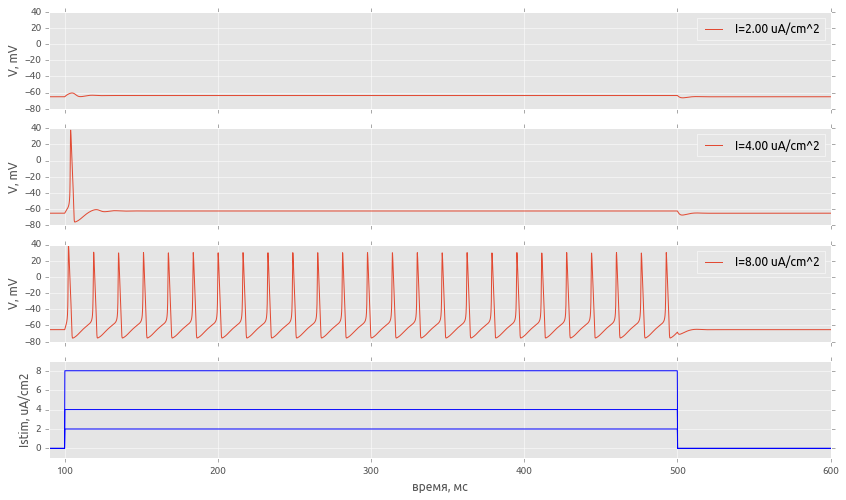

In [24]:
multi_pulse_protocol(hh_ode, [2,4,8])

Обратите внимание на подпороговые колебания потенциала при Istim=4 мкА/см^2

<font color='red'>**Задание:** Определите пороговые значения тока стимуляции, при котором возникают: (1) одиночные ПД, (2) ритмический ответ.</font> 

<font color='red'>**Задание:** Зависит ли частота ритмического ответа от амплитуды возбуждающего тока?</font> 

### Спайк "отскока"

В момент убирания длительной гиперполяризации может возникать ПД, так называемый спайк "отскока":

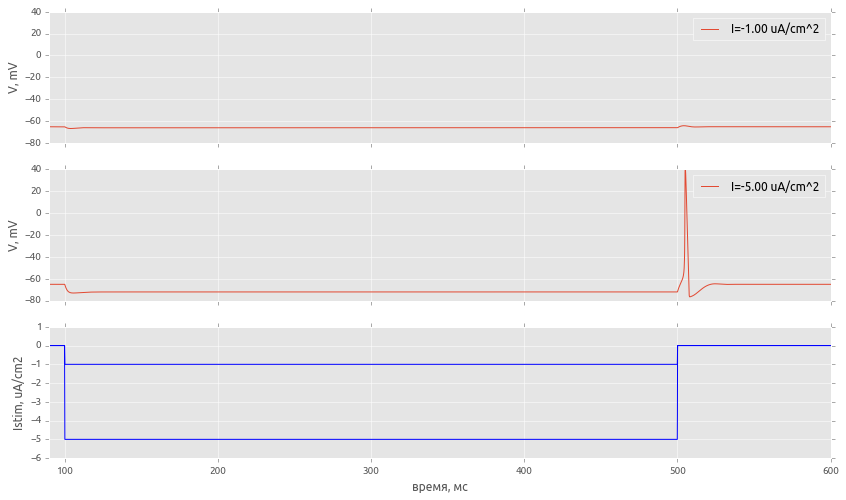

In [25]:
multi_pulse_protocol(hh_ode, [-1,-5])

<font color='red'>**Задание:** Определите пороговые значения амплитуды и длительности гиперполяризующего тока, при котором возникает спайк отскока. </font> 

### Влияние концентрации $[K^+]_o$
Проведем аналогичный опыт при увеличенной концентрации калия снаружи клетки,   $[K^+]_o=30$mM

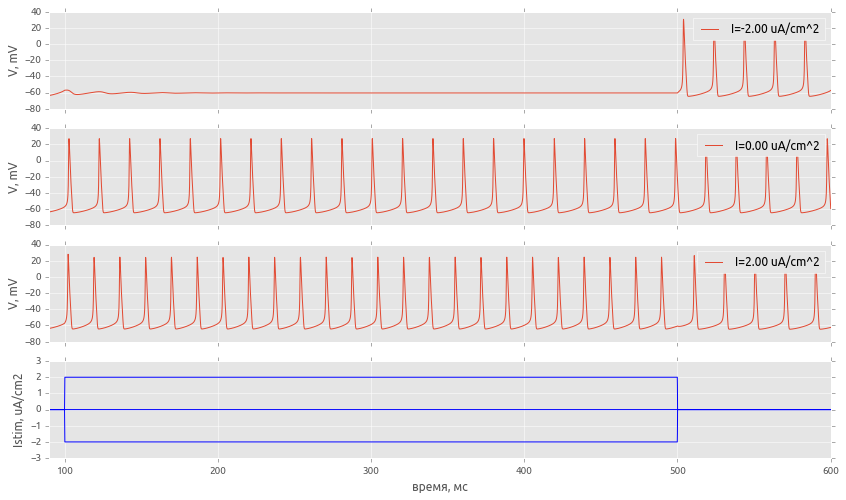

In [26]:
hh_ode.set(pars={'ko':5})

multi_pulse_protocol(hh_ode, [-2,0,2])

<font color='red'>**Задание:** определите максимальную $[K^+]_o$, при которой клетка **не** находится в режиме автоколебаний в отсутствие стимула. Как она зависит от $[K^+]_i$? </font> 

### Влияние концентрации $[Na^+]_i$
Проведем аналогичный опыт при увеличенной концентрации натрия внутри клетки,   $[Na^+]_i=30$mM



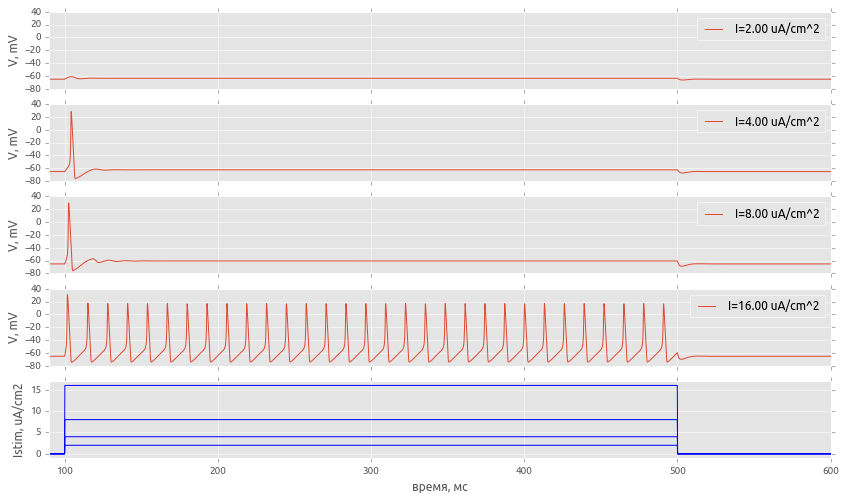

In [27]:
hh_ode.set(pars={'ko':3, 'nai':30})
multi_pulse_protocol(hh_ode, stims=[2,4,8,16])

<font color='red'>**Задание:** Как изменились порог возбуждения и форма ПД? </font> 

In [28]:
# Вернем исходные значения:
hh_ode.set(pars=dict(Istim = 0, ko=3.0, nai=20.0))

### Приближение постоянного поля [\*]

<font color='red'>Задание повышенной сложности:</font>

<font color='blue'>
Формализм Ходжкина-Хаксли подразумевает *линейную* зависимость тока от сдвига потенциала (закон Ома). Уравнение же для потока ионов Гольдмана-Ходжкина-Катца в приближении постоянного поля диктует нелинейную зависимость тока от трансмембранного потенциала (см. выше). 

<ol>
 <li> Замените выражения для ионных токов с вида $i = \bar{g}x^ay^b(V-V_r)$ на вид $i = \bar{P}x^ay^b\frac{z^2F^2V}{RT}\frac{c_i - c_o e^{-\frac{zFV}{RT}}}{1 - e^{-\frac{zFV}{RT}}}$, где $\bar{P}$ -- это максимальная проницаемость для данного иона.
<li> Хорошо ли совпадают две кривые ($I_\infty(V)$) для ионов Na+ и К+ при физиологических значениях потенциала и концентраций?
<li> Как изменится согласие между двумя типами зависимости, если варьировать $[K^+]_o$ и $[K^+]_i$?
<li> Существенно ли изменится поведение и характеристики возбудимости модели?
</ol>
</font>

## Влияние температуры

Ходжкин и Хаксли проводили опыты и описывали кинетику токов при температуре 6 $^\circ$C. Как изменится поведение системы при изменении температуры? Это важно знать, поскольку во многих случаях параметры токов в разных типах нейронов определяют *in vitro* при комнатных условиях, но потом эти данные нужно перенести на реальную температуру тела животного. Как это сделать?

Очевидно, что температура входит в уравнение Нернста для равновесного потенциала. Однако, это не единственное, что меняется при изменении температуры. Поскольку реакции протекают быстрее при более высоких температурах, это должно отразиться на константах скорости кинетик воротных частиц $\alpha_x$ и $\beta_x$ (или, что эквивалентно, в константе скорости $\tau_x$.

Обычно, для описания этой зависимости вводят т.н. коэффициент $q_{10}$, который описывает, во сколько раз ускоряется кинетика воротных частиц при увеличении температуры на 10К: $\tau(V,T) = \tau(V,T_0)q_{10}^\frac{T_0-T}{10}$. Как правило, берут $q_{10}\approx 3$

Модифицируем дифференциальные уравнения для воротных переменных:

In [29]:
QF = Pow(3, 0.1*(celsius-6.0))
mdott = QF*(minf-m)/mtau
hdott = QF*(hinf-h)/htau
ndott = QF*(ninf-n)/ntau

In [30]:
v_init = -65.
#Iramp = Var('Iramp')
hhmodel_t = dst.args(name = 'HH',
                   pars = parameters,
                   fnspecs={'Iramp':(['tx'], 'min(120,0.1*tx)'),
                           'rpulse':(['tx','width'], '0.5*(1 + tanh(100*(tx)) * tanh(100*(-tx+width)))')},
                   auxvars=['Is'],
                   varspecs={'V':'Istim*rpulse(t-100,400)'-Imech, 
                             'm':mdott, 'h':hdott, 'n':ndott, 
                             'Is':'Istim*rpulse(t-100,400)'},
                   tdomain=[0,1000], 
                   xdomain = {'V':[-100, 50], 'm': [0, 1], 'h': [0, 1], 'n': [0, 1]},
                   ics=make_initials(v_init, parameters))
hh_ode_t = dst.Generator.Vode_ODEsystem(hhmodel_t)

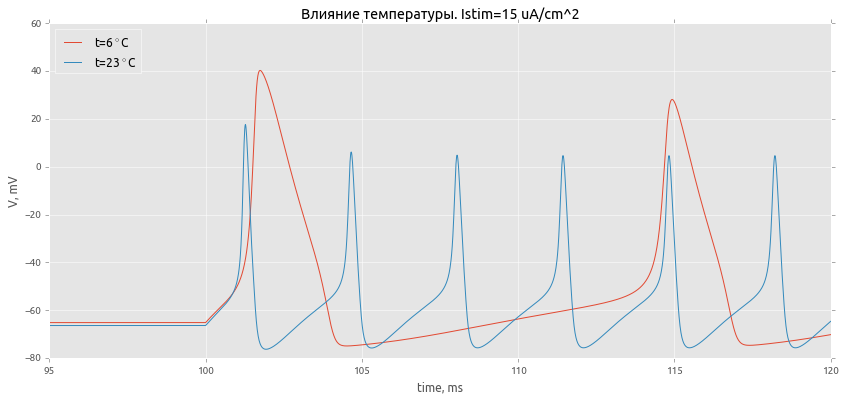

In [31]:
stim = 15

hh_ode_t.set(pars=dict(Istim = stim, celsius=6.))

traj_6 = hh_ode_t.compute('tempdep')
pts_6 = traj_6.sample(dt=0.01)

hh_ode_t.set(pars=dict(Istim = stim, celsius=23.))
traj_23 = hh_ode_t.compute('tempdep')
pts_23 = traj_23.sample(dt=0.01)

figure(figsize=(14,6))
plot(pts_6['t'], pts_6['V'],label='t=6$^\circ$C')
plot(pts_23['t'], pts_23['V'], label='t=23$^\circ$C')

legend(loc='upper left')
xlim(95,120)
xlabel('time, ms')
ylabel('V, mV')
title(u'Влияние температуры. Istim=%d uA/cm^2'%stim)

<font color=red>**Задание:** (1) Объясните наблюдаемые изменения. (2) Изменился ли порог возбуждения?

## Альтернативные варианты параметризации

При моделировании зависимости кинетик воротных переменных Ходжкин и Хаксли исходили из представления о переходе некоторых частиц из закрытого состояния в открытое и обратно с константами $\alpha$ и $\beta$, поэтому они стремились параметризовать именно их зависимости от потенциала $\alpha(V)$, $\beta(V)$. В этом случае кинетика воротной частицы $x$ описывается как $\dot x = \alpha_x(V) (1-x) - \beta_x(V) x$.

При экспериментальных измерениях обычно удобнее описывать кинетику другим (эквивалентным) способом: $\tau_x(V)\dot x = x_\infty(V) - x$, где распределение воротных частиц стремится к равновесному при данном потенциале значению $x_\infty(V)$ с константой времени $\tau_x(V)$. Существует несколько подходов к тому, какими функциями описывать $x_\infty(V)$ и $\tau_\infty(V)$. В наиболее простом варианте зависимость $x_\infty(V)$ описывается функцией Больцмана, а $\tau_x(V)$ -- гауссианом. Такой способ параметризации удобен, потому что позволяет напрямую задавать потенциал, при котором половина "ворот" находится в открытом состоянии, а также крутизну этой зависимости от потенциала.

Функция Больцмана:

\begin{equation}
f(V) = \frac{1}{1 + \exp\frac{V_{1/2}-V}{k}}
\end{equation}

In [32]:
boltzman = Fun(1./(1. + Exp(('Vhalf'- V)/'bk')), ['Vhalf','bk'], 'boltzman')


minf2 = boltzman(-40., 9.)
hinf2 = boltzman(-62., -7.)

ninf2 = boltzman(-53., 15.)

In [33]:
gausstau = Fun('Cbase + Camp*Exp(-(Vmax-V)**2/sigma**2)', ['Vmax', 'sigma', 'Camp','Cbase'], 'gausstau')

mtau2 = gausstau(-38., 30., 0.46, 0.04)
htau2 = gausstau(-67., 20., 7.4, 1.2)
ntau2 = gausstau(-79., 50., 4.7, 1.1)

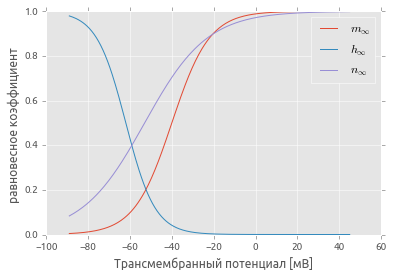

In [34]:
plot(vtest, eval_at('vtest', minf2), label='$m_\infty$')
plot(vtest, eval_at('vtest', hinf2), label='$h_\infty$')
plot(vtest, eval_at('vtest', ninf2), label='$n_\infty$')
legend(loc='best')
xlabel(u'Трансмембранный потенциал [мВ]')
ylabel(u'равновесное коэффициент ')

<font color='red'>**Задание:** Сравните с исходными графиками для кинетики воротных переменных $x_\infty$ и $\tau_x$) в оригинальной модели Х-Х и при альтернативном способе параметризации.  </font> 

Зададим модель с альтернативной параметризацией и приготовим систему уравнений:

In [35]:
hhmodela = dst.args(name = 'HHa',
                   pars = parameters,
                   fnspecs={'Iramp':(['tx'], 'min(120,0.1*tx)'),
                           'rpulse':(['tx','width'], '0.5*(1 + tanh(100*(tx)) * tanh(100*(-tx+width)))')},
                   auxvars=['Is'],
                   varspecs={'V':'Istim*rpulse(t-100,400)'-Imech, 
                             'm':(minf2-m)/mtau2, 'h':(hinf2-h)/htau2, 'n':(ninf2-n)/ntau2, 
                             'Is':'Istim*rpulse(t-100,400)'},
                   tdomain=[0,1000], 
                   xdomain = {'V':[-100, 50], 'm': [0, 1], 'h': [0, 1], 'n': [0, 1]},
                   ics=make_initials(v_init, parameters))
hh_ode_a = dst.Generator.Vode_ODEsystem(hhmodela)

Сравним динамику модели с исходной:

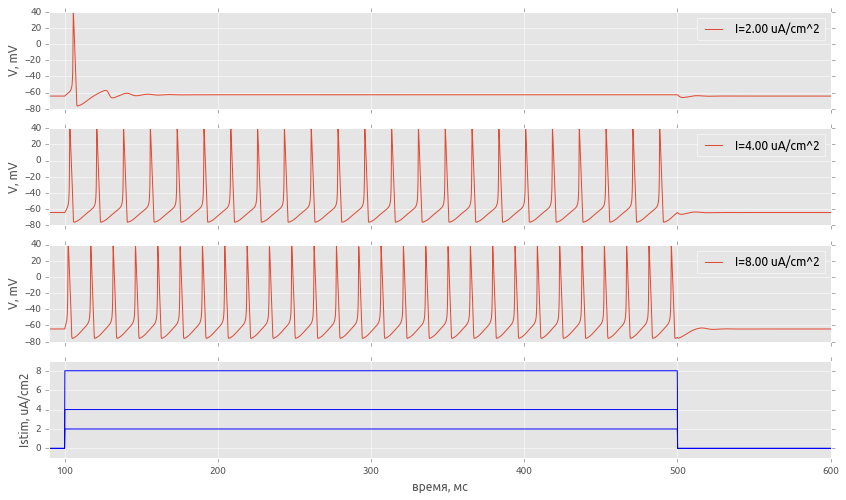

In [36]:
multi_pulse_protocol(hh_ode_a, stims=[2,4,8])

<font color='red'>**Задание:** Как изменились свойства возбудимости модели? </font> 

## Интеграторы и резонаторы

Во многих нейронах К-токи менее чувствительны к потенциалу (активируются при более деполяризованной мембране), чем в оригинальной модели Ходжкина-Хаксли. Сделаем модель такого нейрона и исследуем ее свойства.

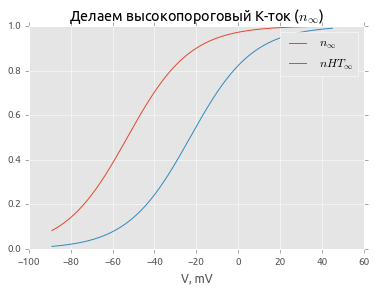

In [37]:
Vshift = 30
ninf3 = boltzman(-53+Vshift, 15.)
ntau3 = gausstau(-79+Vshift, 50., 4.7, 1.1)

plot(vtest, eval_at('vtest', ninf2), label='$n_\infty$')
plot(vtest, eval_at('vtest', ninf3), label='$nHT_\infty$')
legend()
xlabel('V, mV')
title(u"Делаем высокопороговый К-ток ($n_\infty$)")

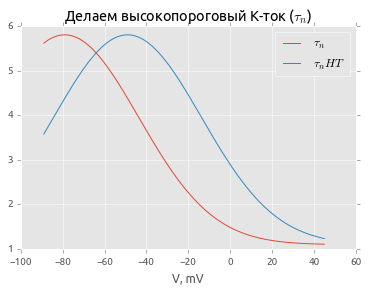

In [38]:
plot(vtest, eval_at('vtest', ntau2), label='$\\tau_n$')
plot(vtest, eval_at('vtest', ntau3), label='$\\tau_nHT$')
legend()
xlabel('V, mV')
title(u"Делаем высокопороговый К-ток ($\\tau_n$)")

In [39]:
v_init = -65.
#Iramp = Var('Iramp')
hhmodel_ht = dst.args(name = 'HH-ht',
                   pars = parameters,
                   fnspecs={'Iramp':(['tx'], 'min(120,0.1*tx)'),
                           'rpulse':(['tx','width'], '0.5*(1 + tanh(100*(tx)) * tanh(100*(-tx+width)))')},
                   auxvars=['Is'],
                   varspecs={'V':'Istim*rpulse(t-100,400)'-(ina + ik + ileak), 
                             'm':(minf2-m)/mtau2, 'h':(hinf2-h)/htau2, 'n':(ninf3-n)/ntau3, 
                             'Is':'Istim*rpulse(t-100,400)'},
                   tdomain=[0,1000], 
                   xdomain = {'V':[-100, 50], 'm': [0, 1], 'h': [0, 1], 'n': [0, 1]},
                   ics=make_initials(v_init, parameters))
hh_ode_ht = dst.Generator.Vode_ODEsystem(hhmodel_ht)

Из-за уменьшения К проводимости около потенциала покоя, такой нейрон находится в автоколебательном режиме.

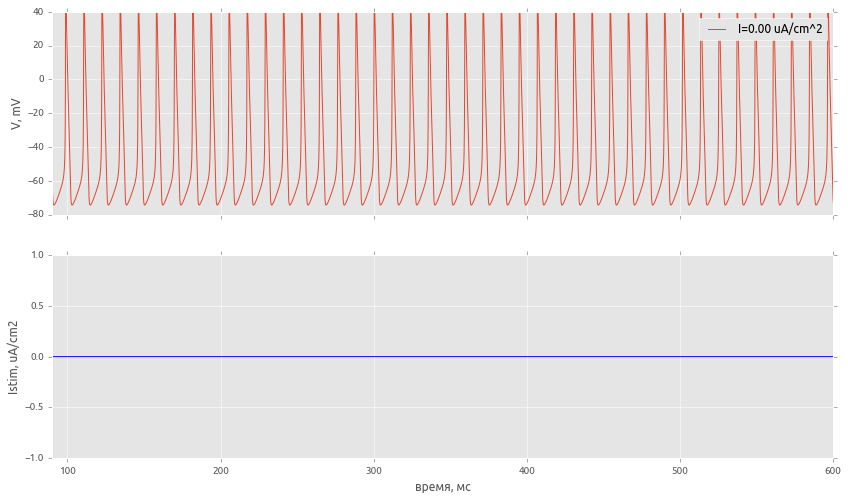

In [40]:
multi_pulse_protocol(hh_ode_ht, stims=[0])

Скомпенсируем уменьшившуюся проводимость по К изменением равновесного потенциала и проводимости утечки так, при отсутствии стимуляции не наблюдались ПД:

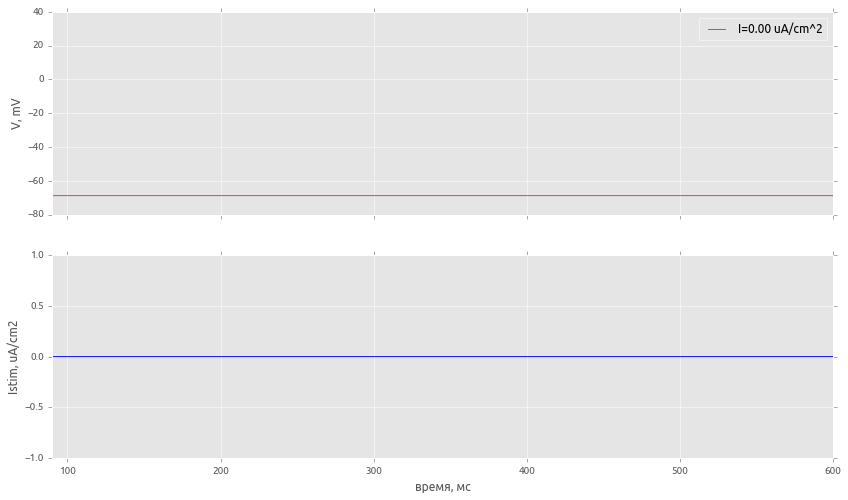

In [41]:
hh_ode_ht.set(pars={'glk':0.5, 'elk':-70},)
multi_pulse_protocol(hh_ode_ht, stims=[0])

Сдвиг порога К-тока приводит к изменению типа возбудимости нейрона. Теперь варьирование амплитуды стимула приводит к  
изменению **задержки** первого ПД и **частоты** ритмического ответа, что не наблюдалось при низкопороговом токе.

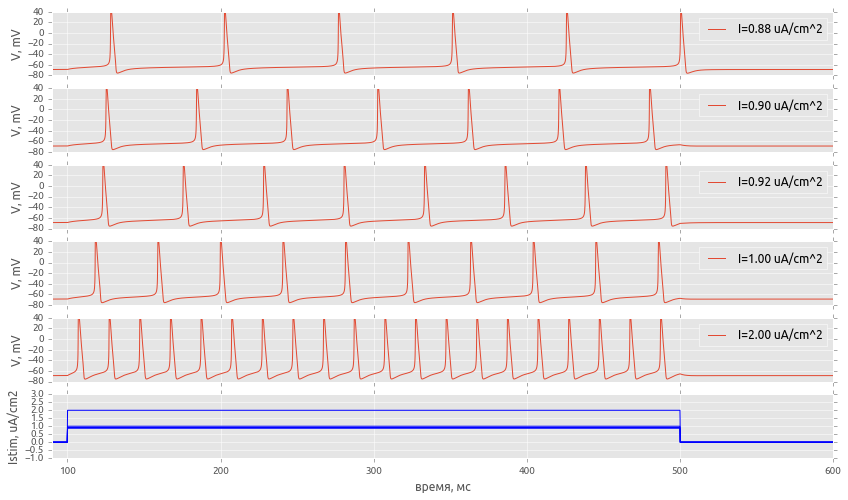

In [42]:
multi_pulse_protocol(hh_ode_ht, stims=[0.88, 0.9, 0.92, 1.0, 2])

<font color=red>**Задание:** (1) Объясните наблюдаемые изменения. (2) Покажите, что аналогичные изменения в проводимости и потенциале реверсии в случае низкопорогового тока не приведут изменению типа возбудимости. (3) Подумайте, как разные типы возбудимости влияют на потенциальные способы обработки информации нейроном.